In [41]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam



In [42]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [43]:
type(img_shape)

tuple

In [44]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

In [45]:
# Build the generator
generator = build_generator(img_shape, z_dim)

# Display the model summary
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               12928     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 784)               101136    
                                                                 
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 114064 (445.56 KB)
Trainable params: 114064 (445.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

In [47]:
# Build the generator
discriminator = build_discriminator(img_shape)

# Display the model summary
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 100609 (393.00 KB)
Trainable params: 100609 (393.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
def build_gan(generator, discriminator):

  model = Sequential()

  # Combined Generator -> Discriminator model
  model.add(generator)
  model.add(discriminator)

  return model


In [49]:
#Build and compile the Discriminator

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer = Adam(),
                      metrics=['Accuracy'])

# Build Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


In [50]:
(X_train, _), (_, _) = mnist.load_data()


In [51]:
X_train.shape


idx = np.random.randint(0, X_train.shape[0], 128)
imgs = X_train[idx]
print(imgs.shape)
print(X_train.shape[0])
print(X_train.shape)

(128, 28, 28)
60000
(60000, 28, 28)


In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [52]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  real = np.ones((batch_size, 1))

  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)


    # ----------------------
    #  Train the Generator
    # ----------------------

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
            (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)





4/4 [==============================] - 0s 590us/step
1000 [D loss: 0.024919, acc.: 100.00%] [G loss: 4.416146]
4/4 [==============================] - 0s 515us/step
2000 [D loss: 0.040450, acc.: 97.66%] [G loss: 6.983790]
4/4 [==============================] - 0s 522us/step
3000 [D loss: 0.035203, acc.: 99.61%] [G loss: 5.538711]
4/4 [==============================] - 0s 518us/step
4000 [D loss: 0.108537, acc.: 96.88%] [G loss: 6.203489]
4/4 [==============================] - 0s 599us/step
5000 [D loss: 0.241227, acc.: 89.06%] [G loss: 3.578184]
4/4 [==============================] - 0s 1ms/step
6000 [D loss: 0.277280, acc.: 90.23%] [G loss: 4.495151]
4/4 [==============================] - 0s 2ms/step
7000 [D loss: 0.270783, acc.: 90.62%] [G loss: 3.945087]
4/4 [==============================] - 0s 582us/step
8000 [D loss: 0.413484, acc.: 79.69%] [G loss: 3.191971]
4/4 [==============================] - 0s 591us/step
9000 [D loss: 0.445262, acc.: 82.42%] [G loss: 3.339159]
4/4 [========

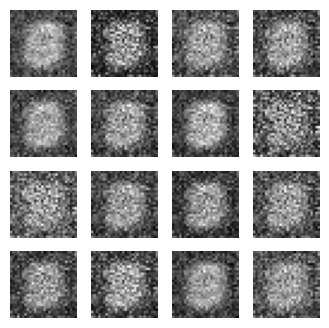

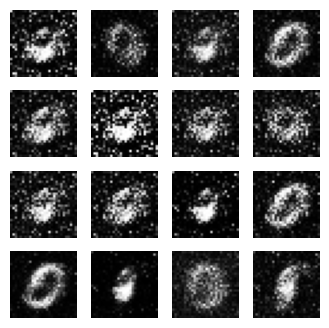

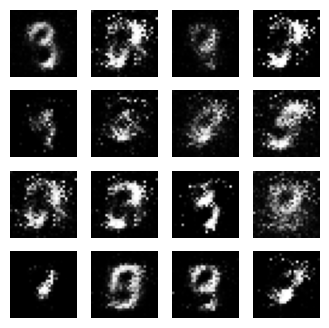

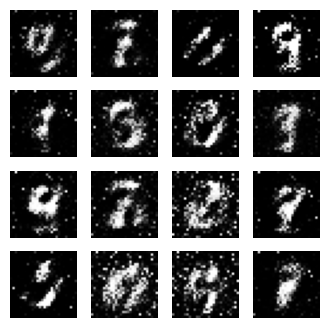

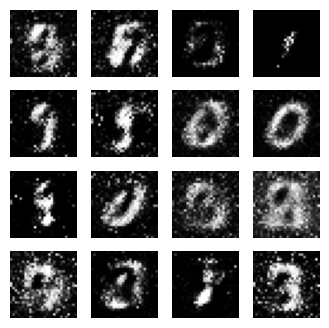

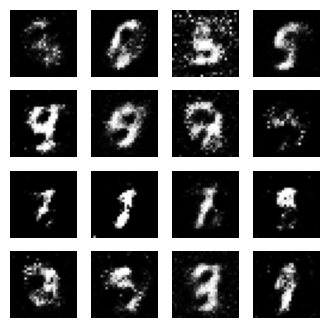

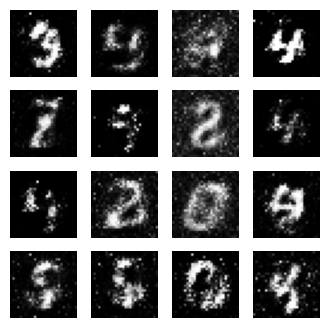

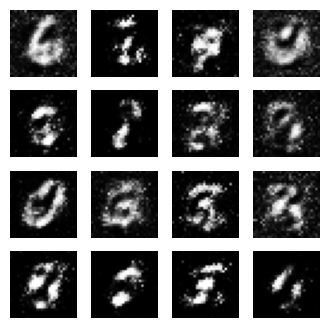

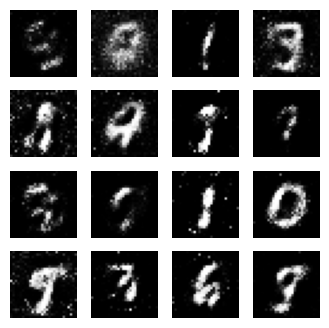

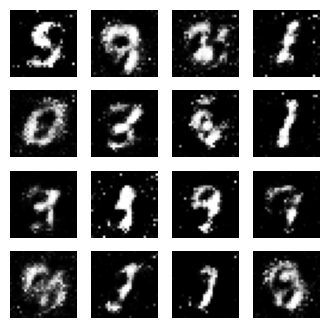

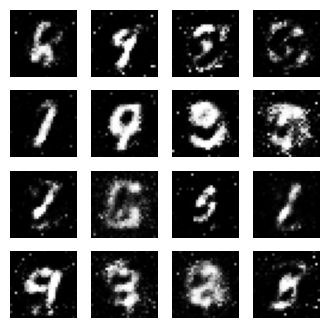

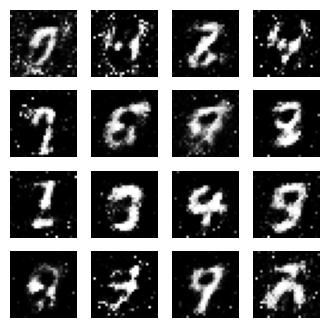

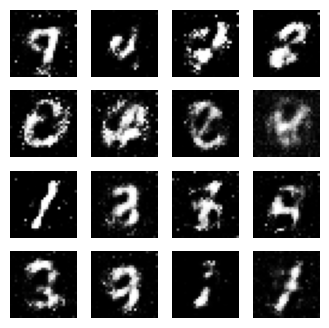

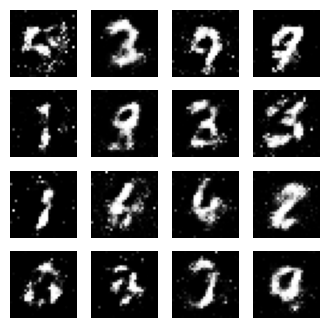

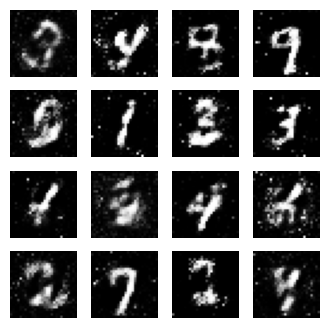

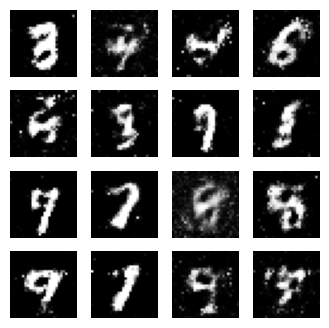

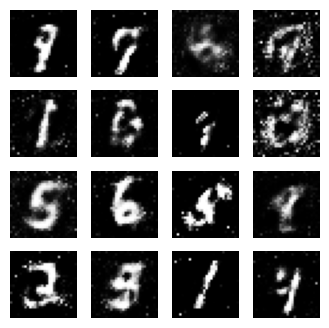

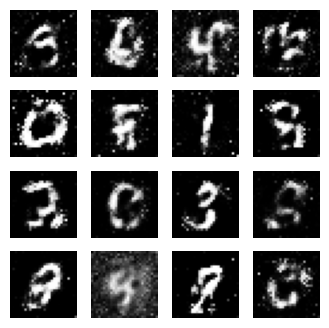

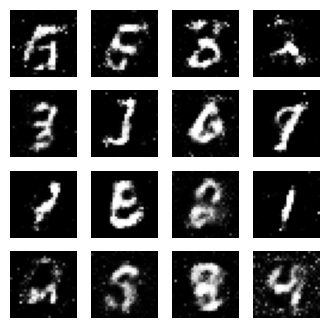

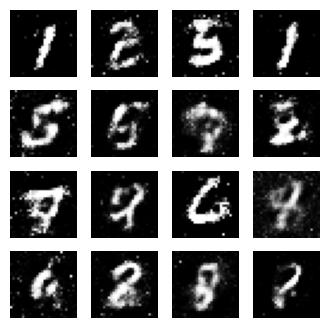

In [14]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

In [21]:

import numpy as np

array1 = np.array([
    [[1,2,3,4], [1,2,3,4], [1,2,3,4]],
    [[1,2,3,4], [1,2,3,4], [1,2,3,4]]
                   ])

In [26]:
array1.ndim

3

In [22]:
expanded = np.expand_dims(array1, axis = 3)

In [17]:
(X_train, _), (_, _) = mnist.load_data()
print(X_train.shape)
X_train = X_train / 127.5 - 1.0
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [21]:
z = np.random.normal(0, 1, (128, 100))
z

array([[ 0.17936823, -0.86068098,  0.48361243, ..., -0.88013539,
        -0.74938128, -1.23355128],
       [ 0.40019898,  1.03728946, -0.28083262, ..., -1.97590186,
         0.99825691,  0.09286894],
       [-0.93229881, -0.11684532,  0.59270079, ..., -1.68588674,
         0.21690676, -1.24826517],
       ...,
       [-1.63962915,  0.56544593, -0.54715145, ..., -0.1970286 ,
        -1.81144879, -0.52991706],
       [-1.33510669, -0.76621078, -1.11388903, ..., -0.64669532,
        -0.44265924, -0.10420741],
       [-0.08481004, -1.72313143,  0.99957039, ...,  1.34312   ,
         1.19859352,  1.1800176 ]])

In [35]:
idx1 = np.random.randint(0, X_train.shape[0], 1)
imgs = X_train[idx1]

In [36]:
z = np.random.normal(0, 1, (batch_size, 100))

In [53]:
gen_imgs = generator.predict(z)
gen_imgs.shape

4/4 [==============================] - 0s 1ms/step


(128, 28, 28, 1)